In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_1586/1799943160.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
import os
import mlflow
os.environ['MLFLOW_TRACKING_URI'] = './mlruns'
mlflow.set_tracking_uri(os.environ.get('MLFLOW_TRACKING_URI'))

## 1



<img src="./images/01.png" width=800>

In [3]:
mlflow.set_experiment('Exercise_1')
# mlflow.start_run(run_name='Exercise_1')

2025/04/06 10:25:39 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_1' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/773631873264077024', creation_time=1743922539674, experiment_id='773631873264077024', last_update_time=1743922539674, lifecycle_stage='active', name='Exercise_1', tags={}>

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torchinfo import summary
from utils import train_simple_network, plot_data_and_predictions, plot_loss, set_seed

/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/utils.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


<Axes: >

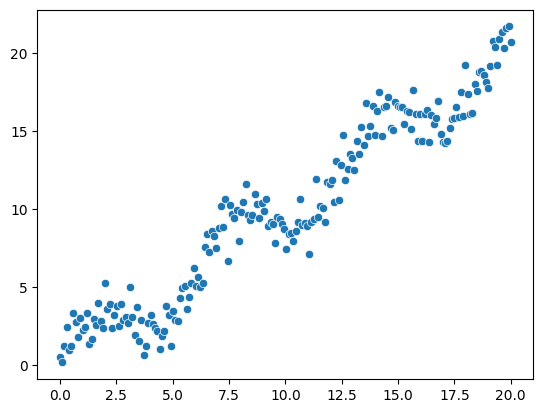

In [5]:
set_seed(42)
X = np.linspace(0, 20, 200)
Y = X + 2 * np.sin(X) + np.random.normal(size = X.shape)
sns.scatterplot(x=X, y=Y)

In [6]:
set_seed(42)
class SimpleRegressionDataset(Dataset):
    def __init__(self, X , Y):
        self.X = X.reshape(-1, 1)
        self.Y = Y.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        Y_tensor = torch.tensor(self.Y[idx], dtype=torch.float32)
        return X_tensor, Y_tensor

training_loader = DataLoader(SimpleRegressionDataset(X, Y), shuffle=True)

In [7]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)


with mlflow.start_run(nested=True, run_name='without_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).numpy()
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch: 100%|██████████| 50/50 [00:31<00:00,  1.61it/s]
2025/04/06 10:26:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:27:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
print(loss[-1])    #This value represents the average loss for the mini-batches during the final epoch of training.
mean_squared_error(Y, Y_pred.ravel())   #This is calculated post-training using the entire dataset, without batch processing or sampling.

(1.9263681689828809, np.float64(3.2934337754510623))

### Scaling Input

In [8]:
from sklearn.preprocessing import StandardScaler

input_scaler = StandardScaler()
scaled_X = input_scaler.fit_transform(X.reshape(-1, 1))
training_loader = DataLoader(SimpleRegressionDataset(scaled_X, Y), shuffle=True)
# mse = train_simple_network(model, loss_func, training_loader, epochs=100)

In [9]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)

with mlflow.start_run(nested=True, run_name='input_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch: 100%|██████████| 50/50 [00:35<00:00,  1.41it/s]
2025/04/06 10:28:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:28:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:28:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


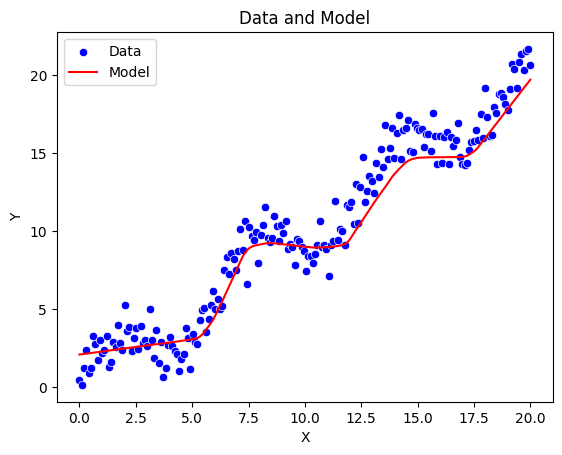

In [49]:
with torch.no_grad():
    Y_pred = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()
plot_data_and_predictions(X, Y, Y_pred)

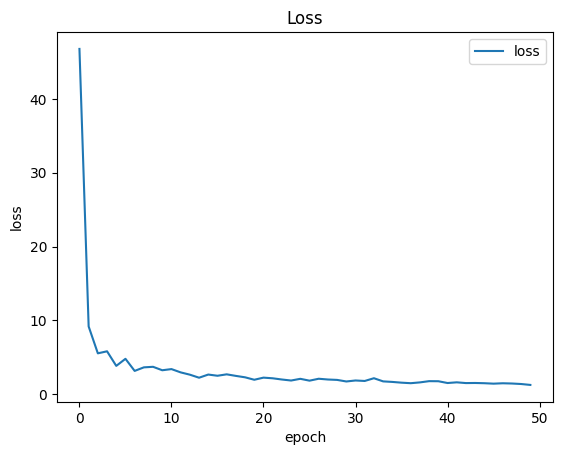

In [50]:
plot_loss(loss)

In [15]:
print(loss[-1])    #This value represents the average loss for the mini-batches during the final epoch of training.
mean_squared_error(Y, Y_pred.ravel())   #This is calculated post-training using the entire dataset, without batch processing or sampling.

1.2727373226408962


np.float64(1.9578474999968185)

### Scaling output

In [10]:
from sklearn.preprocessing import StandardScaler

output_scaler = StandardScaler()
scaled_Y = output_scaler.fit_transform(Y.reshape(-1, 1))


training_loader = DataLoader(SimpleRegressionDataset(X, scaled_Y), shuffle=True)
# mse = train_simple_network(model, loss_func, training_loader, epochs=100)

In [11]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)

with mlflow.start_run(nested=True, run_name='output_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred_scaled = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).numpy()
    Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]
2025/04/06 10:29:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:29:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:29:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Axes: >

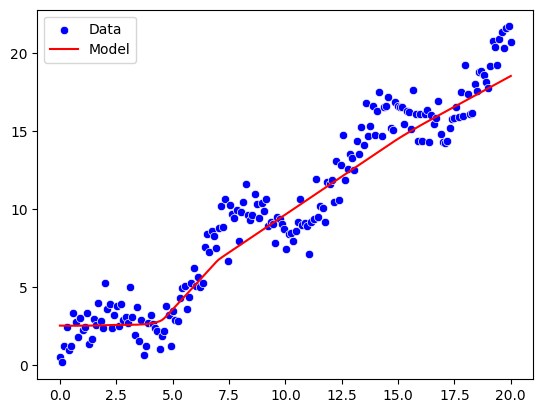

In [ ]:
with torch.no_grad():
    Y_pred_scaled = model(torch.tensor(X.reshape(-1, 1), dtype=torch.float32)).numpy()

Y_pred = output_scaler.inverse_transform(Y_pred_scaled)

plot_data_and_predictions(X, Y, Y_pred)

In [18]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y, Y_pred.ravel()), mean_squared_error(scaled_Y, Y_pred_scaled.ravel()) 

(np.float64(2.9571463943845604), np.float64(0.08577446697027132))

### Scaling Input and output

In [12]:
from sklearn.preprocessing import StandardScaler

out_in_scaler = StandardScaler()
scaled_X = out_in_scaler.fit_transform(X.reshape(-1, 1))
scaled_Y = out_in_scaler.fit_transform(Y.reshape(-1, 1))


training_loader = DataLoader(SimpleRegressionDataset(scaled_X, scaled_Y), shuffle=True)
# mse = train_simple_network(model, loss_func, training_loader, epochs=100)

In [13]:
set_seed(42)
n = 212
layers = 5
in_features = 1
out_features = 1

activation = nn.LeakyReLU()
sequential_layer = [
    nn.Linear(in_features, n),
    activation
]
for _ in range(layers):
    sequential_layer.append(nn.Linear(n, n))
    sequential_layer.append(activation)
sequential_layer.append(nn.Linear(n, out_features))
model = nn.Sequential(*sequential_layer)

loss_func = nn.MSELoss(reduction='sum')
epochs = 50
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optimizer = optim.SGD(model.parameters(), lr=0.001)

with mlflow.start_run(nested=True, run_name='input_output_scaling'):
    mlflow.log_params({
        'epochs': epochs,
        'device': device,
        'optimizer': optimizer.defaults,
        'loss_func': loss_func.__class__.__name__
    })
    with open('model_summary.txt', 'w') as f:
        f.write(str(summary(model)))
    mlflow.log_artifact('model_summary.txt')
    
    loss = train_simple_network(
        model=model,
        loss_func=loss_func,
        training_loader= training_loader,
        optimizer=optimizer,
        disable_tqdm=False,
        epochs=epochs)
    
    mlflow.log_figure(plot_loss(loss), 'loss.png')
    with torch.no_grad():
        Y_pred_scaled = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()
    Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
    mlflow.log_figure(plot_data_and_predictions(X, Y, Y_pred), 'data_model.png')
    mlflow.pytorch.log_model(model, 'model')
    mlflow.log_metric('loss_entire_dataset', mean_squared_error(Y, Y_pred.ravel()))  #Loss on the entire dataset, not on a single batch.

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 100%|██████████| 50/50 [00:37<00:00,  1.34it/s]
2025/04/06 10:31:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:31:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/06 10:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Axes: >

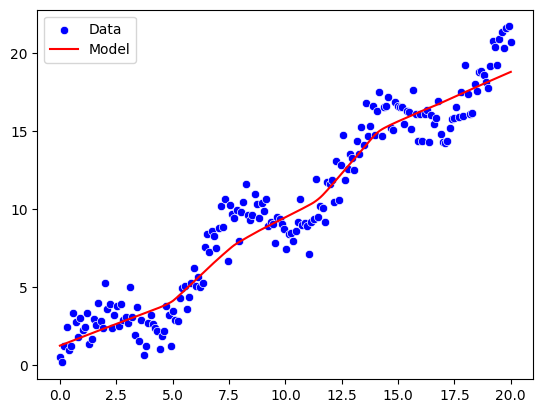

In [ ]:
with torch.no_grad():
    Y_pred_scaled = model(torch.tensor(scaled_X.reshape(-1, 1), dtype=torch.float32)).numpy()

Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
plot_data_and_predictions(X, Y, Y_pred)

In [22]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y, Y_pred.ravel()), mean_squared_error(scaled_Y, Y_pred_scaled.ravel())

(np.float64(1.9855890171986135), np.float64(0.057593641620202585))

### Results from MLflow

mse:

<img src='./images/mse_entire_dataset.png' width=800>

training loss:

<img src='./images/train_loss.png' width=800>

<img src='./images/train_loss_output_scaling.png' width=800>

## 2

<img src='./images/02.png' width=800>

This code integrates **Optuna** for automated hyperparameter optimization with **MLflow** for experiment tracking. It trains a deep learning model on a binary classification task and evaluates its performance using the Area Under the Curve (AUC) metric. The script optimizes hyperparameters such as batch size, learning rate, number of layers, neurons per layer, and activation function **to maximize the AUC score**, ensuring the model achieves superior predictive performance. Key artifacts, metrics, and parameters are logged with MLflow, providing a structured and reproducible workflow for model development and evaluation.

In [4]:
mlflow.set_experiment('Exercise_2')

2025/04/07 08:18:01 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/218575834700796214', creation_time=1744001281532, experiment_id='218575834700796214', last_update_time=1744001281532, lifecycle_stage='active', name='Exercise_2', tags={}>

In [5]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary

/home/spakdel/miniconda3/envs/python3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
random_state = 42
set_seed(random_state)

X_train, Y_train = make_moons(n_samples=8000, noise=0.4, random_state=random_state)
X_valid, Y_valid = make_moons(n_samples=200, noise=0.4, random_state=random_state)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(Y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                            torch.tensor(Y_valid, dtype=torch.long))

in_features = 2
out_features =2
loss_func = nn.CrossEntropyLoss()
activation_functions = {
'ReLU': nn.ReLU(),
'Tanh': nn.Tanh(),
'LeakyReLU': nn.LeakyReLU(),
'Sigmoid': nn.Sigmoid()
}

In [7]:
def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid AUC', label='valid AUC')
    plt.xlabel('epoch')
    plt.ylabel('valid AUC')
    plt.title('valid AUC')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig
    

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
import optuna


optuna.logging.set_verbosity(optuna.logging.ERROR)
def champion_callback(study, frozen_trial):
    winner = study.user_attrs.get('winner', None)
    if winner is None:
        print(f'Initial trial {frozen_trial.number} achived value: {frozen_trial.value}')
    elif winner != study.best_value and study.best_value:   # second condition is for preventing zero devision
        improvment_percent = (abs(winner - study.best_value) / abs(study.best_value)) * 100
        print(f'Trial {frozen_trial.number} achived value: {frozen_trial.value} with {improvment_percent:.4f}% improvment')
    study.set_user_attr('winner', study.best_value)


In [10]:
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


def objective(trial):
    params = {
    'batch_size': trial.suggest_int('batch_size', 16, 256),
    'device': device,
    'epochs' : epochs,
    # 'optimizer': optimizer.defaults,
    'loss_function': loss_func.__class__.__name__,
    'learning_rate': trial.suggest_float('lr', 1e-8, 1, log=True),
    'hidden_neurons': trial.suggest_int("neuron_per_layer", in_features, 500),
    'layers': trial.suggest_int("hidden_layers", 1, 20),
    'activation': trial.suggest_categorical("activation", list(activation_functions.keys()))
    }
    sequential_layer = [
        nn.Linear(in_features, params['hidden_neurons']),
        activation_functions[params['activation']]
    ]
    for _ in range(params['layers']):
        sequential_layer.append(nn.Linear(params['hidden_neurons'], params['hidden_neurons']))
        sequential_layer.append(activation_functions[params['activation']])
    sequential_layer.append(nn.Linear(params['hidden_neurons'], out_features))

    model = nn.Sequential(*sequential_layer)
    
    # run_name = f'trial_lr_{params["learning_rate"]:.8f}'
    run_name = f'trial: {trial.number}'
    with mlflow.start_run(nested=True, run_name=run_name):

        optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
        params['optimizer'] = optimizer.defaults
        mlflow.log_params(params)

        train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'],shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=params['batch_size'])
        
        with open ("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")

        model.apply(weight_reset)
        fc_results = train_network(
            model=model,
            loss_func=loss_func,
            train_loader=train_dataloader,
            valid_loader=valid_dataloader,
            epochs=epochs,
            optimizer=optimizer,
            score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
            device=device,
            checkpont_file_save='model.pth'
        )
        
        input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        signature = ModelSignature(inputs=input_schema, outputs=output_schema)
        mlflow.pytorch.log_model(model, "model", signature=signature)
        mlflow.log_figure(plot_results(fc_results), "valid_AUC.png")
    return  fc_results['valid AUC'].iloc[-1]


In [11]:
epochs = 20
# run_name = "second_attempt"
# with mlflow.start_run():
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, callbacks=[champion_callback])
champion_trial = study.best_trial
print(f"Champion trial: {champion_trial.number} with value {champion_trial.value}")

Epoch: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]
2025/04/07 08:19:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:19:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Initial trial 0 achived value: 0.12995


Epoch: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]
2025/04/07 08:19:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:19:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Trial 1 achived value: 0.72805 with 82.1510% improvment


Epoch: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]
2025/04/07 08:20:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:20:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Epoch: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]
2025/04/07 08:20:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged 

Trial 4 achived value: 0.9032 with 19.3922% improvment


Epoch: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]
2025/04/07 08:21:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:21:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Epoch: 100%|██████████| 20/20 [00:36<00:00,  1.85s/it]
2025/04/07 08:22:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged 

Trial 9 achived value: 0.9294 with 2.8190% improvment


Epoch: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]
2025/04/07 08:24:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:24:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Epoch: 100%|██████████| 20/20 [00:44<00:00,  2.22s/it]
2025/04/07 08:25:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged 

Trial 11 achived value: 0.9301 with 0.0753% improvment


Epoch: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]
2025/04/07 08:25:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:25:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Trial 12 achived value: 0.9320999999999999 with 0.2146% improvment


Epoch: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
2025/04/07 08:26:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 08:26:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Epoch: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]
2025/04/07 08:26:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged 

Champion trial: 12 with value 0.9320999999999999


## 3

<img src='./images/03.png' width=800>

This script addresses a modified version of the original problem from the book. The original task involved writing a function (resume_simple_network) that loads a model checkpoint from disk, restores both the optimizer and model states, and continues training to reach a specified total number of epochs.

In this solution, I extended the problem to incorporate MLflow and Optuna skills. Instead of merely restoring a checkpoint, the script loads the best-performing model (logged with MLflow in the previous task) and resumes training with additional epochs. This approach leverages MLflow's experiment tracking and Optuna's hyperparameter optimization, enhancing reproducibility and automation in the model development process.

In [15]:
mlflow.set_experiment('Exercise_3')

2025/04/07 10:14:06 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_3' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/233476924229105941', creation_time=1744008246854, experiment_id='233476924229105941', last_update_time=1744008246854, lifecycle_stage='active', name='Exercise_3', tags={}>

In [16]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary

In [17]:
random_state = 42
set_seed(random_state)

X_train, Y_train = make_moons(n_samples=8000, noise=0.4, random_state=random_state)
X_valid, Y_valid = make_moons(n_samples=200, noise=0.4, random_state=random_state)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(Y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                            torch.tensor(Y_valid, dtype=torch.long))

In [18]:
def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid AUC', label='valid AUC')
    plt.xlabel('epoch')
    plt.ylabel('valid AUC')
    plt.title('valid AUC')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig
    

In [ ]:
run_id = '219aed50bb7f4f8cbe70429ade80c1a5' #best valid auc from previuos exercise
checkpoint_local_path = mlflow.artifacts.download_artifacts(artifact_path="model.pth", run_id=run_id)
print(checkpoint_local_path)
checkpoint = torch.load(checkpoint_local_path)

/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/218575834700796214/219aed50bb7f4f8cbe70429ade80c1a5/artifacts/model.pth


/tmp/ipykernel_1586/496767390.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_local_path)


In [13]:
from mlflow import MlflowClient
client = MlflowClient()
run_data = client.get_run(run_id).data
run_data

<RunData: metrics={'train AUC': 0.9327616875,
 'train Acc': 0.85975,
 'train F1': 0.860932077342588,
 'train_loss': 0.33126768881970264,
 'valid AUC': 0.9320999999999999,
 'valid Acc': 0.835,
 'valid F1': 0.819672131147541,
 'valis_loss': 0.38746872544288635}, params={'activation': 'ReLU',
 'batch_size': '172',
 'device': 'cpu',
 'epochs': '20',
 'hidden_neurons': '483',
 'layers': '7',
 'learning_rate': '0.9838326800227287',
 'loss_function': 'CrossEntropyLoss',
 'optimizer': "{'lr': 0.9838326800227287, 'momentum': 0, 'dampening': 0, "
              "'weight_decay': 0, 'nesterov': False, 'maximize': False, "
              "'foreach': None, 'differentiable': False, 'fused': None}"}, tags={'mlflow.log-model.history': '[{"run_id": "219aed50bb7f4f8cbe70429ade80c1a5", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2025-04-07 04:55:41.302860", "flavors": '
                             '{"pytorch": {"model_data": "data", '
     

In [14]:
run_data.params

{'device': 'cpu',
 'layers': '7',
 'epochs': '20',
 'activation': 'ReLU',
 'optimizer': "{'lr': 0.9838326800227287, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None}",
 'learning_rate': '0.9838326800227287',
 'batch_size': '172',
 'loss_function': 'CrossEntropyLoss',
 'hidden_neurons': '483'}

In [20]:
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


params = run_data.params
epochs = 30
in_features = 2
out_features = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params['device'] = device
params['epochs'] = epochs
loss_func = nn.CrossEntropyLoss()
activation_functions = {
'ReLU': nn.ReLU(),
'Tanh': nn.Tanh(),
'LeakyReLU': nn.LeakyReLU(),
'Sigmoid': nn.Sigmoid()
}
sequential_layer = [
    nn.Linear(in_features, int(params['hidden_neurons'])),
    activation_functions[params['activation']]
]
for _ in range(int(params['layers'])):
    sequential_layer.append(nn.Linear(int(params['hidden_neurons']), int(params['hidden_neurons'])))
    sequential_layer.append(activation_functions[params['activation']])
sequential_layer.append(nn.Linear(int(params['hidden_neurons']), out_features))

model = nn.Sequential(*sequential_layer)
optimizer = torch.optim.SGD(model.parameters(), lr=float(params['learning_rate']))

train_dataloader = DataLoader(train_dataset, batch_size=int(params['batch_size']),shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=int(params['batch_size']))

with mlflow.start_run(nested=True, run_name='resume_best_auc'):
    mlflow.log_params(params)

    
    with open ("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    fc_results = train_network(
        model=model,
        loss_func=loss_func,
        train_loader=train_dataloader,
        valid_loader=valid_dataloader,
        epochs=epochs,
        optimizer=optimizer,
        score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
        device=device,
        checkpont_file_save='model.pth',
        checkpoint_file_load=checkpoint_local_path
    )
    
    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)
    mlflow.pytorch.log_model(model, "model", signature=signature)
    mlflow.log_figure(plot_results(fc_results), "valid_AUC.png")

/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/utils.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

loading model ....


Epoch: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]
2025/04/07 10:17:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 10:17:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


## 4

<img src='./images/04.png' width=800>

To address the original problem, I modified the train_simple_network function to save a version of the model every x epochs. Instead of saving models with different filenames locally, which could potentially fill the hard drive, I store the models in MLflow. By leveraging MLflow, I can keep track of models efficiently without worrying about storage limitations. This approach makes it easy to revisit specific versions of the model and analyze their performance.

In [21]:
mlflow.set_experiment('Exercise_4')

2025/04/07 10:31:47 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_4' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/203838178005775626', creation_time=1744009307431, experiment_id='203838178005775626', last_update_time=1744009307431, lifecycle_stage='active', name='Exercise_4', tags={}>

In [24]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary
from mlflow import MlflowClient
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


random_state = 42
set_seed(random_state)

X_train, Y_train = make_moons(n_samples=8000, noise=0.4, random_state=random_state)
X_valid, Y_valid = make_moons(n_samples=200, noise=0.4, random_state=random_state)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(Y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                            torch.tensor(Y_valid, dtype=torch.long))


def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid AUC', label='valid AUC')
    plt.xlabel('epoch')
    plt.ylabel('valid AUC')
    plt.title('valid AUC')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig
    
run_id = '219aed50bb7f4f8cbe70429ade80c1a5' #best valid auc from previuos exercise

client = MlflowClient()
run_data = client.get_run(run_id).data

params = run_data.params
epochs = 30
in_features = 2
out_features = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params['device'] = device
params['epochs'] = epochs
loss_func = nn.CrossEntropyLoss()
activation_functions = {
'ReLU': nn.ReLU(),
'Tanh': nn.Tanh(),
'LeakyReLU': nn.LeakyReLU(),
'Sigmoid': nn.Sigmoid()
}
sequential_layer = [
    nn.Linear(in_features, int(params['hidden_neurons'])),
    activation_functions[params['activation']]
]
for _ in range(int(params['layers'])):
    sequential_layer.append(nn.Linear(int(params['hidden_neurons']), int(params['hidden_neurons'])))
    sequential_layer.append(activation_functions[params['activation']])
sequential_layer.append(nn.Linear(int(params['hidden_neurons']), out_features))

model = nn.Sequential(*sequential_layer)
optimizer = torch.optim.SGD(model.parameters(), lr=float(params['learning_rate']))

train_dataloader = DataLoader(train_dataset, batch_size=int(params['batch_size']),shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=int(params['batch_size']))

with mlflow.start_run(nested=True, run_name='save_every_x_epochs'):
    mlflow.log_params(params)

    
    with open ("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    fc_results = train_network(
        model=model,
        loss_func=loss_func,
        train_loader=train_dataloader,
        valid_loader=valid_dataloader,
        epochs=epochs,
        optimizer=optimizer,
        score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
        device=device,
        checkpoint_file_save='model.pth',
        checkpoint_every_x=10
    )
    
    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)
    mlflow.pytorch.log_model(model, "model", signature=signature)
    mlflow.log_figure(plot_results(fc_results), "valid_AUC.png")

Epoch: 100%|██████████| 30/30 [00:47<00:00,  1.57s/it]
2025/04/07 10:37:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/07 10:37:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


### Without mlflow:

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm.autonotebook import tqdm
import time
from collections import defaultdict
import pandas as pd
from utils import run_epoch

def resum_better_network(model,
                        optimizer,
                        loss_func,
                        train_loader,
                        val_loader=None,
                        epochs=50,
                        device='cpu',
                        score_funcs=None,
                        checkpoint_file_load=None,
                        checkpoint_file_save=None,
                        lr=0.001,
                        checkpoint_every_x=None,
                        ):
    model.to(device)
    optimizer = optimizer(model.parameters(), lr=lr)

    if checkpoint_file_load:
        checkpoint = torch.load(checkpoint_file_load,  weights_only=False)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        results = checkpoint['results']
        total_train_time = checkpoint['results']['total time'][-1]
    else:
        results = defaultdict(list)
        start_epoch = 0
        total_train_time = 0
    for epoch in tqdm(range(start_epoch, epochs), desc='Epoch'):
        model.train()
        
        total_train_time += run_epoch(model,
                                    optimizer,
                                    train_loader,
                                    loss_func,
                                    device,
                                    results,
                                    score_funcs,
                                    prefix='train',
                                    desc='training',
                                    )

        results['total time'].append(total_train_time)
        results['epoch'].append(epoch)
        
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                run_epoch(model,
                        optimizer,
                        train_loader,
                        loss_func,
                        device,
                        results,
                        score_funcs,
                        prefix='valid',
                        desc='validating',
                        )
        if checkpoint_every_x and (epoch+1) % checkpoint_every_x == 0:
            torch.save(
                {
                'results': results,
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                },
                f'{checkpoint_file_save.split('.')[0]}_{epoch+1}.pth')

    if checkpoint_file_save is not None:
        torch.save(
            {
            'results': results,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },
            f'{checkpoint_file_save.split('.')[0]}_final_({epoch+1}).pth')
    return pd.DataFrame.from_dict(results)

## 5

<img src='./images/05.png' width=800>

In [2]:
import mlflow
mlflow.set_experiment('Exercise_5')

2025/04/07 20:38:52 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_5' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/548671726767221527', creation_time=1744045733016, experiment_id='548671726767221527', last_update_time=1744045733016, lifecycle_stage='active', name='Exercise_5', tags={}>

In [3]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary
from mlflow import MlflowClient
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


random_state = 42
set_seed(random_state)

X_train, Y_train = make_moons(n_samples=8000, noise=0.4, random_state=random_state)
X_valid, Y_valid = make_moons(n_samples=200, noise=0.4, random_state=random_state)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(Y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                            torch.tensor(Y_valid, dtype=torch.long))


def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid AUC', label='valid AUC')
    plt.xlabel('epoch')
    plt.ylabel('valid AUC')
    plt.title('valid AUC')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

def plot_results_layers(data_list, close=True):
    sns.lineplot(x=range(len(data_list)), y=data_list)
    plt.xlabel('layers')
    plt.ylabel('valid AUC')
    plt.title('valid AUC per layer')
    plt.xticks(range(len(data_list)))
    plt.legend()
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

run_id = '219aed50bb7f4f8cbe70429ade80c1a5' # best valid auc from exercise 2

client = MlflowClient()
run_data = client.get_run(run_id).data

params = run_data.params
epochs = 20
in_features = 2
out_features = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params['device'] = device
params['epochs'] = epochs
loss_func = nn.CrossEntropyLoss()
activation_functions = {
'ReLU': nn.ReLU(),
'Tanh': nn.Tanh(),
'LeakyReLU': nn.LeakyReLU(),
'Sigmoid': nn.Sigmoid()
}

train_dataloader = DataLoader(train_dataset, batch_size=int(params['batch_size']),shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=int(params['batch_size']))

results_layers = []
layers = 20
for layer in range(layers):
    print(f'trainig: {layer} layers')
    params['layers'] = layer
    sequential_layer = [
    nn.Linear(in_features, int(params['hidden_neurons'])),
    activation_functions[params['activation']]
    ]
    for _ in range(layer):
        sequential_layer.append(nn.Linear(int(params['hidden_neurons']), int(params['hidden_neurons'])))
        sequential_layer.append(activation_functions[params['activation']])
    sequential_layer.append(nn.Linear(int(params['hidden_neurons']), out_features))

    model = nn.Sequential(*sequential_layer)
    optimizer = torch.optim.SGD(model.parameters(), lr=float(params['learning_rate']))

    with mlflow.start_run(nested=True, run_name=f'layers_{layer}'):
        mlflow.log_params(params)

        
        with open ("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")
        # model.apply(weight_reset)
        fc_results = train_network(
            model=model,
            loss_func=loss_func,
            train_loader=train_dataloader,
            valid_loader=valid_dataloader,
            epochs=epochs,
            optimizer=optimizer,
            score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
            device=device,
            # checkpoint_file_save='model.pth',
            # checkpoint_every_x=10,
        )
        
        # input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        # output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        # signature = ModelSignature(inputs=input_schema, outputs=output_schema)
        # mlflow.pytorch.log_model(model, "model", signature=signature)
        mlflow.log_figure(plot_results(fc_results), "valid_AUC.png")
    results_layers.append(fc_results['valid AUC'].iloc[-1])
mlflow.log_figure(plot_results_layers(results_layers), 'valid_auc_per_layer.png')

/home/spakdel/miniconda3/envs/python3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainig: 0 layers


Epoch: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


trainig: 1 layers


Epoch: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


trainig: 2 layers


Epoch: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


trainig: 3 layers


Epoch: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


trainig: 4 layers


Epoch: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


trainig: 5 layers


Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


trainig: 6 layers


Epoch: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


trainig: 7 layers


Epoch: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


trainig: 8 layers


Epoch: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


trainig: 9 layers


Epoch: 100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


trainig: 10 layers


Epoch: 100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


trainig: 11 layers


Epoch: 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


trainig: 12 layers


Epoch: 100%|██████████| 20/20 [00:55<00:00,  2.76s/it]


trainig: 13 layers


Epoch: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


trainig: 14 layers


Epoch: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


trainig: 15 layers


Epoch: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


trainig: 16 layers


Epoch: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


trainig: 17 layers


Epoch: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


trainig: 18 layers


Epoch: 100%|██████████| 20/20 [01:02<00:00,  3.14s/it]


trainig: 19 layers


Epoch: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]
/tmp/ipykernel_1840/1475513000.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<img src='./images/valid_auc_layers.png' width=800>

<img src='./images/valid_auc_per_layer.png' width=800>

## 6

<img src='./images/06.png' width=800>

In [9]:
mlflow.set_experiment('Exercise_6')

2025/04/07 18:14:00 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_6' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/688296389628558366', creation_time=1744037040958, experiment_id='688296389628558366', last_update_time=1744037040958, lifecycle_stage='active', name='Exercise_6', tags={}>

In [10]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary
from mlflow import MlflowClient
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


random_state = 42
set_seed(random_state)

X_train, Y_train = make_moons(n_samples=8000, noise=0.4, random_state=random_state)
X_valid, Y_valid = make_moons(n_samples=200, noise=0.4, random_state=random_state)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(Y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                            torch.tensor(Y_valid, dtype=torch.long))


def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid AUC', label='valid AUC')
    plt.xlabel('epoch')
    plt.ylabel('valid AUC')
    plt.title('valid AUC')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

def plot_results_hidden_neurons(data_list, close=True):
    sns.lineplot(x=range(100, 100*(len(data_list)+1), 100), y=data_list)
    plt.xlabel('hidden neurons')
    plt.ylabel('valid AUC')
    plt.title('valid AUC per hidden neurons')
    plt.xticks(range(100, 100*(len(data_list)+1), 100))
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

run_id = '219aed50bb7f4f8cbe70429ade80c1a5' # best valid auc from exercise 2

client = MlflowClient()
run_data = client.get_run(run_id).data

params = run_data.params
epochs = 20
in_features = 2
out_features = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params['device'] = device
params['epochs'] = epochs
loss_func = nn.CrossEntropyLoss()
activation_functions = {
'ReLU': nn.ReLU(),
'Tanh': nn.Tanh(),
'LeakyReLU': nn.LeakyReLU(),
'Sigmoid': nn.Sigmoid()
}

train_dataloader = DataLoader(train_dataset, batch_size=int(params['batch_size']),shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=int(params['batch_size']))

results_neurons = []
neurons = 1000
for neuron in range(100, neurons, 100):
    print(f'trainig: {neuron} neurons')
    params['hidden_neurons'] = neuron
    sequential_layer = [
    nn.Linear(in_features, neuron),
    activation_functions[params['activation']]
    ]
    for _ in range(int(params['layers'])):
        sequential_layer.append(nn.Linear(neuron, neuron))
        sequential_layer.append(activation_functions[params['activation']])
    sequential_layer.append(nn.Linear(neuron, out_features))

    model = nn.Sequential(*sequential_layer)
    optimizer = torch.optim.SGD(model.parameters(), lr=float(params['learning_rate']))

    with mlflow.start_run(nested=True, run_name=f'neurons_{neuron}'):
        mlflow.log_params(params)

        
        with open ("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")
        # model.apply(weight_reset)
        fc_results = train_network(
            model=model,
            loss_func=loss_func,
            train_loader=train_dataloader,
            valid_loader=valid_dataloader,
            epochs=epochs,
            optimizer=optimizer,
            score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
            device=device,
            # checkpoint_file_save='model.pth',
            # checkpoint_every_x=10,
        )
        
        # input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        # output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        # signature = ModelSignature(inputs=input_schema, outputs=output_schema)
        # mlflow.pytorch.log_model(model, "model", signature=signature)
        mlflow.log_figure(plot_results(fc_results), "valid_AUC.png")
    results_neurons.append(fc_results['valid AUC'].iloc[-1])
mlflow.log_figure(plot_results_hidden_neurons(results_neurons), 'valid_auc_per_hidden_neurons.png')

trainig: 100 neurons


Epoch: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


trainig: 200 neurons


Epoch: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


trainig: 300 neurons


Epoch: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


trainig: 400 neurons


Epoch: 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


trainig: 500 neurons


Epoch: 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


trainig: 600 neurons


Epoch: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


trainig: 700 neurons


Epoch: 100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


trainig: 800 neurons


Epoch: 100%|██████████| 20/20 [00:54<00:00,  2.73s/it]


trainig: 900 neurons


Epoch: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


<img src='./images/valid_auc_hidden_neurons.png' width=800>

<img src='./images/valid_auc_per_hidden_neurons.png' width=800>

## 7

<img src='./images/07.png' width=800>

In [2]:
import mlflow
mlflow.set_experiment('Exercise_7')

2025/04/07 17:42:03 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_7' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/904989942481923738', creation_time=1744035123832, experiment_id='904989942481923738', last_update_time=1744035123832, lifecycle_stage='active', name='Exercise_7', tags={}>

In [3]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary
import optuna
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

/home/spakdel/miniconda3/envs/python3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [5]:
random_state = 42
set_seed(random_state)
dataset = TensorDataset(
    torch.tensor(data.data, dtype=torch.float32),
    torch.tensor(data.target, dtype=torch.long)
    )
train_size = int(len(data.data) * 0.8)
valid_size = len(data.data) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

in_features = dataset.tensors[0].shape[1]
out_features = len(torch.unique(dataset.tensors[1]))
loss_func = nn.CrossEntropyLoss()
activation_functions = {
'ReLU': nn.ReLU(),
'Tanh': nn.Tanh(),
'LeakyReLU': nn.LeakyReLU(),
'Sigmoid': nn.Sigmoid()
}

In [ ]:
def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid F1', label='valid F1')
    plt.xlabel('epoch')
    plt.ylabel('valid F1')
    plt.title('valid F1')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

optuna.logging.set_verbosity(optuna.logging.ERROR)

def champion_callback(study, frozen_trial):
    winner = study.user_attrs.get('winner', None)
    if winner is None:
        print(f'Initial trial {frozen_trial.number} achived value: {frozen_trial.value}')
    elif winner != study.best_value and study.best_value:   # second condition is for preventing zero devision
        improvment_percent = (abs(winner - study.best_value) / abs(study.best_value)) * 100
        print(f'Trial {frozen_trial.number} achived value: {frozen_trial.value} with {improvment_percent:.4f}% improvment')
    study.set_user_attr('winner', study.best_value)


def objective(trial):
    params = {
    'batch_size': trial.suggest_int('batch_size', 16, 256),
    'device': device,
    'epochs' : epochs,
    # 'optimizer': optimizer.defaults,
    'loss_function': loss_func.__class__.__name__,
    'learning_rate': trial.suggest_float('lr', 1e-8, 1, log=True),
    'hidden_neurons': trial.suggest_int("neuron_per_layer", in_features, 500),
    'layers': trial.suggest_int("hidden_layers", 1, 20),
    'activation': trial.suggest_categorical("activation", list(activation_functions.keys()))
    }
    sequential_layer = [
        nn.Linear(in_features, params['hidden_neurons']),
        activation_functions[params['activation']]
    ]
    for _ in range(params['layers']):
        sequential_layer.append(nn.Linear(params['hidden_neurons'], params['hidden_neurons']))
        sequential_layer.append(activation_functions[params['activation']])
    sequential_layer.append(nn.Linear(params['hidden_neurons'], out_features))

    model = nn.Sequential(*sequential_layer)
    
    # run_name = f'trial_lr_{params["learning_rate"]:.8f}'
    run_name = f'trial: {trial.number}'
    with mlflow.start_run(nested=True, run_name=run_name):

        optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
        params['optimizer'] = optimizer.defaults
        mlflow.log_params(params)

        train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'],shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=params['batch_size'])
        
        with open ("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")

        model.apply(weight_reset)
        fc_results = train_network(
            model=model,
            loss_func=loss_func,
            train_loader=train_dataloader,
            valid_loader=valid_dataloader,
            epochs=epochs,
            optimizer=optimizer,
            score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
            device=device,
            # checkpont_file_save='model.pth'
        )
        
        # input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, in_features))])
        # output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, out_features))])
        # signature = ModelSignature(inputs=input_schema, outputs=output_schema)
        # mlflow.pytorch.log_model(model, "model", signature=signature)
        mlflow.log_figure(plot_results(fc_results), "valid_F1.png")
    return  fc_results['valid F1'].iloc[-1]

epochs = 20
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, callbacks=[champion_callback])
champion_trial = study.best_trial
print(f"Champion trial: {champion_trial.number} with value {champion_trial.value}")

Epoch: 100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


Initial trial 0 achived value: 0.7472527472527473


Epoch: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Trial 7 achived value: 0.9154929577464789 with 18.3770% improvment


Epoch: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Champion trial: 7 with value 0.9154929577464789


<img src='./images/exercise07.png' width=800>

<img src='./images/train_valid_f1.png' width=800>

## 8

<img src='./images/08.png' width=800>

In [1]:
import mlflow
mlflow.set_experiment('Exercise_8')

2025/04/08 14:06:53 INFO mlflow.tracking.fluent: Experiment with name 'Exercise_8' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_02/mlruns/476357225522364280', creation_time=1744108613358, experiment_id='476357225522364280', last_update_time=1744108613358, lifecycle_stage='active', name='Exercise_8', tags={}>

In [2]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import optuna
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import (train_network, accuracy_score_wrapper, 
                f1_score_wrapper, roc_auc_score_micro_wrapper, 
                weight_reset, set_seed)
from torchinfo import summary
from mlflow import MlflowClient
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature


random_state = 42
set_seed(random_state)

X_train, Y_train = make_moons(n_samples=8000, noise=0.4, random_state=random_state)
X_valid, Y_valid = make_moons(n_samples=200, noise=0.4, random_state=random_state)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(Y_train, dtype=torch.long))
valid_dataset = TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                            torch.tensor(Y_valid, dtype=torch.long))

batch_sizes = [2 ** i for i in range(1, 12)]

def plot_results(data_df, close=True):
    sns.lineplot(data_df, x='epoch', y='valid AUC', label='valid AUC')
    plt.xlabel('epoch')
    plt.ylabel('valid AUC')
    plt.title('valid AUC')
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

def plot_results_batch_sizes(data_list, close=True):
    sns.lineplot(x=batch_sizes, y=data_list)
    plt.xlabel('batch sizes')
    plt.ylabel('valid Acc')
    plt.title('valid Acc per batch size')
    # plt.xticks(batch_sizes)
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

def plot_time_batch_sizes(data_list, close=True):
    sns.lineplot(x=batch_sizes, y=data_list)
    plt.xlabel('batch sizes')
    plt.ylabel('total time')
    plt.title('total time per batch size')
    # plt.xticks(batch_sizes)
    fig = plt.gcf()
    if close:
        plt.close()
    return fig

epochs = 20
in_features = 2
out_features = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params = {'device': device,
        'epochs': epochs}
loss_func = nn.CrossEntropyLoss()


model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
params['optimizer'] = optimizer.defaults
results_batch_sizes = []
time_batch_sizes = []
for batch_size in batch_sizes:
    print(f'trainig: {batch_size} batch sizes')
    params['batch_size'] = batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
    with mlflow.start_run(nested=True, run_name=f'batch_size_{batch_size}'):
        mlflow.log_params(params)
        
        with open ("model_summary.txt", "w") as f:
            f.write(str(summary(model)))
        mlflow.log_artifact("model_summary.txt")
        # model.apply(weight_reset)
        fc_results = train_network(
            model=model,
            loss_func=loss_func,
            train_loader=train_dataloader,
            valid_loader=valid_dataloader,
            epochs=epochs,
            optimizer=optimizer,
            score_funcs={'Acc':accuracy_score_wrapper, 'F1':f1_score_wrapper, 'AUC':roc_auc_score_micro_wrapper },
            device=device,
            # checkpoint_file_save='model.pth',
            # checkpoint_every_x=10,
        )
        
        # input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        # output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 2))])
        # signature = ModelSignature(inputs=input_schema, outputs=output_schema)
        # mlflow.pytorch.log_model(model, "model", signature=signature)
        mlflow.log_figure(plot_results(fc_results), "valid_AUC.png")
    results_batch_sizes.append(fc_results['valid Acc'].iloc[-1])
    time_batch_sizes.append(fc_results['total time'].iloc[-1])
mlflow.log_figure(plot_results_batch_sizes(results_batch_sizes), 'valid_acc_per_batch_sizes.png')
mlflow.log_figure(plot_time_batch_sizes(time_batch_sizes), 'time_per_batch_sizes.png')


/home/spakdel/miniconda3/envs/python3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trainig: 2 batch sizes


Epoch: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


trainig: 4 batch sizes


Epoch: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


trainig: 8 batch sizes


Epoch: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


trainig: 16 batch sizes


Epoch: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


trainig: 32 batch sizes


Epoch: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


trainig: 64 batch sizes


Epoch: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


trainig: 128 batch sizes


Epoch: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


trainig: 256 batch sizes


Epoch: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]


trainig: 512 batch sizes


Epoch: 100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


trainig: 1024 batch sizes


Epoch: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


trainig: 2048 batch sizes


Epoch: 100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


<img src='./images/time_per_batch_sizes.png' width=800>

<img src='./images/valid_acc_per_batch_sizes.png' width=800>